README:

Before running (you can run all), here's what you have to change:

1) make sure you have access to the inhouse_game_data shared folder and your gdrive is mounted

2) api_key: might need to refresh a new riot api key

3) make sure guest_list is populated with any non-intel players

4) make any updates to PLAYER_ROLE_PREF as desired
  
tjmas is a 5 digit number, with each digit corresponding to how much you want 

*   the role in top, jungle, mid, adc, supp order. 0 means you will never get the role, 9 means you want it the most. Values are normalized (e.g. 12400 = 24800)

5) make sure tournament_code is the code used in the previous inhouse game, and ign is the summoner name of someone that played in that game

6) run all -> share outputs as desired, use matchmaking tool for next game. don't forget to use battlefy or something to generate new tourney code

TODO: auto lobby code creation, bot integration, sort match json by game start not lobby creation, +/- stats after each game, heuristic for h+qual, parallelize role perm, recreate match history




# Code

In [1]:
import trueskill
from cassiopeia import Summoner
import cassiopeia as cass
import numpy as np
import pandas as pd
import random
import itertools
import bisect
import os
import json
import ipywidgets as widgets
import IPython
import requests
import collections
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import time
import imgkit
from pathlib import Path
local = 'google.colab' not in str(get_ipython())


In [2]:
# RESET AFTER MATCH BELOW 

#code for last played match
tournament_code = 'NA04b80-601c01eb-fb37-4d95-b0ca-fccf8d1971c9'
#ign of someone who played in that game
ign = "TheGatorMan"
pull_last_match = False
#secret key
api_key = ''

In [3]:
# Avoids scroll-in-the-scroll in the entire Notebook
if not local:
    from IPython.display import Javascript
    def resize_colab_cell():
      display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'))
    get_ipython().events.register('pre_run_cell', resize_colab_cell)
    
def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

IS_NOTEBOOK = is_notebook()

In [4]:
cass.set_riot_api_key(api_key)

In [5]:
version = requests.get('https://ddragon.leagueoflegends.com/api/versions.json').json()[0]
champs = requests.get('https://ddragon.leagueoflegends.com/cdn/{}/data/en_US/champion.json'.format(version)).json()
CHAMP_ICON_URL = 'https://ddragon.leagueoflegends.com/cdn/{}/img/champion/{{}}.png'.format(version)
champs_by_key = {int(champ['key']): champ for champ in champs['data'].values()}

# Configurables

In [6]:
if local:
    smurf_path = 'smurfs.json'
else:
    smurf_path = '/content/drive/MyDrive/inhouse_rolepref/smurfs.json'
with open(smurf_path,'r') as f:
  SMURFS= json.load(f)

if local:
    rolepref_path = 'rolepref.json'
else:
    rolepref_path = '/content/drive/MyDrive/inhouse_rolepref/rolepref.json'
with open(rolepref_path,'r') as f:
  PLAYER_ROLE_PREF = json.load(f)

In [7]:
from match_processing import *

def format_ratings(ratings, comprehensive, out_dir = None):
    if out_dir is not None:
        out_fn = str(Path(out_dir)  / 'ratings.png')
        options = {'width': 1600}
        if comprehensive:
            imgkit.from_string(
                ratings[["Rating", "Rank", "Record", "Streak", "μ", "σ", "KDA", "avg time", "CSpM",'GpM',"DMGpM","DMGpG",'VisionpM',"PP SIZE","Champs"]]
                .rename(columns={"μ": "MMR", "σ": "conf", "PP SIZE": "PP SIZE (in.)"})
                .style.format({
                            "Rating": "{:0.3f}",
                            "MMR": "{:0.3f}",
                            "conf": "{:0.3f}",
                            'Champs': lambda champs: ' '.join(
                                '<img style="height:24px" src="{}" />'.format(CHAMP_ICON_URL.format(champ[0]))
                                for champ in collections.Counter(champs).most_common()
                            )
                        })
                        .set_properties(
                            subset=["Rating", "Rank", "Record", "MMR", "conf", "KDA", "avg time", "CSpM",'GpM','DMGpM','DMGpG','VisionpM'], **{"text-align": "right"}
                        )
                        .to_html(),out_fn,options=options)
        else:
            imgkit.from_string(
            ratings[["Rating", "Rank", "Record", "Streak", "μ", "KDA", "avg time", "CSpM",'GpM',"DMGpM","DMGpG",'VisionpM',"Champs"]]
            .rename(columns={"μ": "MMR", "PP SIZE": "PP SIZE (in.)", "Champs": "Most Played"})
            .style.format({
                        "Rating": "{:0.3f}",
                        "MMR": "{:0.3f}",
                        #"conf": "{:0.3f}",
                        'Most Played': lambda champs: ' '.join(
                            '<img style="height:24px" src="{}" />'.format(CHAMP_ICON_URL.format(champ[0]))
                            for champ in collections.Counter(champs).most_common(5)
                        )
                    })
                    .set_properties(
                        subset=["Rating", "Rank", "Record", "MMR", "KDA", "avg time", "CSpM",'GpM','DMGpM','DMGpG','VisionpM'], **{"text-align": "right","font-family": "Terminal"}
                    )
                    .to_html(),out_fn,options=options)
    if IS_NOTEBOOK:
        if comprehensive:
            return IPython.display.HTML(
                ratings[["Rating", "Rank", "Record", "Streak", "μ", "σ", "KDA", "avg time", "CSpM",'GpM',"DMGpM","DMGpG",'VisionpM',"PP SIZE","Champs"]]
                .rename(columns={"μ": "MMR", "σ": "conf", "PP SIZE": "PP SIZE (in.)"})
                .style.format({
                            "Rating": "{:0.3f}",
                            "MMR": "{:0.3f}",
                            "conf": "{:0.3f}",
                            'Champs': lambda champs: ' '.join(
                                '<img style="height:24px" src="{}" />'.format(CHAMP_ICON_URL.format(champ[0]))
                                for champ in collections.Counter(champs).most_common()
                            )
                        })
                        .set_properties(
                            subset=["Rating", "Rank", "Record", "MMR", "conf", "KDA", "avg time", "CSpM",'GpM','DMGpM','DMGpG','VisionpM'], **{"text-align": "right"}
                        )
                        .render(escape=False)
            )
        else:
            return IPython.display.HTML(
                ratings[["Rating", "Rank", "Record", "Streak", "μ", "KDA", "avg time", "CSpM",'GpM',"DMGpM","DMGpG",'VisionpM',"Champs"]]
                .rename(columns={"μ": "MMR", "PP SIZE": "PP SIZE (in.)", "Champs": "Most Played"})
                .style.format({
                            "Rating": "{:0.3f}",
                            "MMR": "{:0.3f}",
                            #"conf": "{:0.3f}",
                            'Most Played': lambda champs: ' '.join(
                                '<img style="height:24px" src="{}" />'.format(CHAMP_ICON_URL.format(champ[0]))
                                for champ in collections.Counter(champs).most_common(5)
                            )
                        })
                        .set_properties(
                            subset=["Rating", "Rank", "Record", "MMR", "KDA", "avg time", "CSpM",'GpM','DMGpM','DMGpG','VisionpM'], **{"text-align": "right"}
                        )
                        .render(escape=False)
            )

In [8]:
from matchmaking import get_role_pref

def display_matchmaking(ratings,PLAYER_ROLE_PREF=PLAYER_ROLE_PREF,sortby='quality'):
    PLAYERS_PER_SIDE = 5
    PLAYERS_PER_GAME = PLAYERS_PER_SIDE * 2
    ROLES = 'tjmas'
    ROLE_PERMUTATIONS = [''.join(p) for p in itertools.permutations(ROLES)] 
    random.shuffle(ROLE_PERMUTATIONS)

    DUO_LIST = [('Ahrizona','ANiceSunset')]

    def show_players(x):
        if len(x) > PLAYERS_PER_GAME:
            print("Too many players selected")
        else:
            print(
                "Matchmaking for {{{}}}{}\n".format(
                    ", ".join(x),
                    " + {} new players".format(PLAYERS_PER_GAME - len(x))
                    if len(x) < PLAYERS_PER_GAME
                    else "",
                )
            )

    def toggle(name):
        return widgets.ToggleButton(value=False, description=name, disabled=False,)

    def textbox(name):
        return widgets.Text(value='', placeholder='mmr, TJMAS', description=name, disabled=False)

    def do_matchmaking(current_players):
        # player_ratings = {
        #     player: ratings.loc[player, "trueskill.Rating"]
        #     for player in current_players
        # }
        player_ratings = {}
        for player in current_players:
          if type(player)==tuple:#',' in player:
            player_name = player[0]
            player_input = player[1]
            player_ratings[player_name] = trueskill.Rating(float(player_input.split(', ')[0]))
            PLAYER_ROLE_PREF[player_name] = player_input.split(', ')[1]
          else:
            player_ratings[player] = ratings.loc[player, "trueskill.Rating"]
        print(player_ratings)
        for i in range(PLAYERS_PER_GAME - len(current_players)):
            player_ratings["New player #{}".format(i + 1)] = trueskill.Rating()
        players = player_ratings.keys()

        def avg_mmr(team):
            return sum(player_ratings[player].mu for player in team) / PLAYERS_PER_SIDE

        def normalize_map(role_map):
            if not role_map.isnumeric():
              role_map = '11111' if role_map == 'f' else ''.join(['1' if r in role_map else '0' for r in ROLES])
            total = sum([float(j) for j in role_map])
            norm_map = [float(j)/total for j in role_map]
            return norm_map

        def happiness(team,team_roles):
            happiness = 0
            for i,player in enumerate(team):
              happiness_map = normalize_map(PLAYER_ROLE_PREF.get(player,ROLES))
              h = happiness_map[ROLES.index(team_roles[i])]
              if h == 0:
                return 0
              happiness+=h

            return happiness

        matchups = list()
        print('############################\nanalyzing role permutations...\n############################')
        start_anal = time.time()
        for team1 in itertools.combinations(players, PLAYERS_PER_SIDE):
            team2 = tuple(player for player in players if player not in team1)
            if avg_mmr(team1) > avg_mmr(team2):
                continue
            quality = trueskill.quality(
                (
                    tuple(player_ratings[player] for player in team1),
                    tuple(player_ratings[player] for player in team2),
                )
            )
            #find optimal role permutation if any
            max_happy = -1
            max_t1_h = -1
            max_t2_h = -1
            for t1_roles in ROLE_PERMUTATIONS:
              for t2_roles in ROLE_PERMUTATIONS:
                t1_happy = happiness(team1,t1_roles)
                t2_happy = happiness(team2,t2_roles)
                match_happiness = (t1_happy * t2_happy) / (1 + abs(t1_happy-t2_happy)) #maybe sqrt in denom for less harsh penalty
                if match_happiness>max_happy:
                  max_happy = match_happiness
                  max_t1_h = t1_happy
                  max_t2_h = t2_happy
                  team1_roles = [n+' ('+t1_roles[i]+')' for i,n in enumerate(team1)]
                  team2_roles = [n+' ('+t2_roles[i]+')' for i,n in enumerate(team2)]
            matchups.append((quality, max_t1_h, max_t2_h, max_happy, team1, team1_roles, team2, team2_roles))
        end_anal = time.time()-start_anal
        print('anal cumplete: '+str(end_anal)+'s')

        num_matchups_displayed = 10
        matchup_counter = 0
        quality_threshold = 0.5
        if sortby=='happiness':
          matchups.sort(key=lambda x: x[3], reverse=True)
        elif sortby=='quality':
          matchups.sort(reverse=True)
        print('$$$$$$$$$$$$$$$$$$$$$$$$$$$\nLISTING MATCHUPS BY '+sortby.upper()+'\n$$$$$$$$$$$$$$$$$$$$$$$$$$$')
        for quality, t1_happy, t2_happy, match_happiness, team1, team1_roles, team2, team2_roles in matchups:#[:12]:
            if matchup_counter==num_matchups_displayed or quality<quality_threshold:
              if quality<quality_threshold:
                continue#print('remaining matchup qualities are dogshit')
              break
            #check role satisfaction
            # t1_good = False
            # t1_roles= False
            # t2_roles= False
            # for rp in ROLE_PERMUTATIONS:
            #   if np.all([rp[i] in get_role_pref(p) for i,p in enumerate(team1)]):
            #     t1_roles = rp
            #     t1_good=True
            #     break  
            # if t1_good:
            #   for rp in ROLE_PERMUTATIONS:
            #     if np.all([rp[i] in get_role_pref(p) for i,p in enumerate(team2)]):
            #       t2_roles=rp
            #       break
            if match_happiness>0:#t1_roles and t2_roles:
              print("\n*********OPTION {}*********\nQuality {:.6f}\tHappiness Coefficient {:.3f}".format(matchup_counter+1,quality, match_happiness))
              team1_roles_pretty = ', '.join([team1_roles[z].ljust(20) for z in [np.where(['('+s+')' in t for t in team1_roles])[0][0] for s in ROLES]])
              team2_roles_pretty = ', '.join([team2_roles[z].ljust(20) for z in [np.where(['('+s+')' in t for t in team2_roles])[0][0] for s in ROLES]])
              print(
                  "Team 1 (avg MMR {:.3f}, happiness {:.3f}): {}".format(
                      avg_mmr(team1), t1_happy, team1_roles_pretty
                  )
              )
              print(
                  "Team 2 (avg MMR {:.3f}, happiness {:.3f}): {}".format(
                      avg_mmr(team2), t2_happy, team2_roles_pretty
                  )
              )
              matchup_counter+=1
            else:
              print('role assignment failed')
              # print("\nQuality {:.6f}".format(quality))
              # print(
              #     "Team 1 (average MMR {:.3f}): {}".format(
              #         avg_mmr(team1), ", ".join(team1)
              #     )
              # )
              # print(
              #     "Team 2 (average MMR {:.3f}): {}".format(
              #         avg_mmr(team2), ", ".join(team2)
              #     )
              # )
        if matchup_counter==0:
          print('no valid matchups found')
    #rated players
    toggles = {
        name: toggle(name)
        for name in sorted(ratings.index.values, key=lambda s: s.lower())
    }
    new_players = {
        name: textbox(name)
        for name in ["newplayer"+str(x+1) for x in range(3)]
    }
    out = widgets.Output()

    def observer(_):
        values = [name for name, toggle in toggles.items() if toggle.value] + [name for name, newplayer in new_players.items() if newplayer.value != '']
        with out:
            IPython.display.clear_output(wait=True)
            show_players(values)

    for toggle in toggles.values():
        toggle.observe(observer, "value")

    left_widgets = list(toggles.values()) + list(new_players.values())
    run_btn = widgets.Button(description="Find matches", button_style="success")

    def on_click_run(_):
        values = [name for name, toggle in toggles.items() if toggle.value] + [(name, newplayer.value) for name, newplayer in new_players.items() if newplayer.value != '']
        with out:
            print('a')
            print(values)
            do_matchmaking(values)

    run_btn.on_click(on_click_run)
    left_widgets.append(run_btn)

    box = widgets.HBox((widgets.VBox(left_widgets), out))
    box.layout.height = "60rem"
    box.layout.width = "auto"
    display(box)
    observer(None)

In [9]:
from match_stats import *

In [10]:
from synergy import *

# Pull Latest Match

In [11]:
if pull_last_match == True:
  tf = Summoner(name=ign,region="NA")
  match_ids = [x.id for x in tf.match_history]

  found_match = False
  for i,match_id in enumerate(match_ids):
    if str(match_id)[:3]!='NA1':
      old_match_id = match_id
      match_id = 'NA1_'+str(old_match_id)
      print('the fucking API sucks dick (inconsistent naming): '+str(old_match_id)+' -> '+match_id)
    match_history_call = "https://americas.api.riotgames.com/lol/match/v5/matches/"+match_id+"?api_key="+api_key

    x = requests.get(match_history_call)

    mh = json.loads(x.text)

    if mh['info']['tournamentCode']==tournament_code:
      found_match = True
      print('inhouse game found for '+ign+' '+str(i+1)+' game(s) ago! ('+match_id+')')
      #sanity check to make sure it's the right game
      print('=============================================')
      print('VERIFY TEAMS BELOW ARE ACCURATE FOR LAST GAME')
      print('=============================================')
      print('\n')
      team_ids = np.unique([mh['info']['participants'][i]['teamId'] for i in range(len(mh['info']['participants']))])
      _ = [print('team '+str(i+1)+': '+''.join(str([mh['info']['participants'][k]['summonerName']+' ('+mh['info']['participants'][k]['championName']+')' for k in range(len(mh['info']['participants'])) if mh['info']['participants'][k]['teamId']==j]))) for i,j in enumerate(team_ids)]
      print('\n')
      json_path = '/content/drive/MyDrive/inhouse_game_data/'+match_id+'.json'
      if os.path.isfile(json_path):
        print('Game '+match_id+' already seems to be downloaded, double check?')
      else:
        with open(json_path,'w') as f:
          json.dump(mh,f,indent=4)
        print('Game '+match_id+' added!')
      break
  if not found_match:
    print("tournament code not found in match history")

# Data

In [12]:
#note: we rename NA1_4219362169 to NA1_4219252610 to preserve match order. 611 was created via tourney code
#but 169 was played first, so we rename 169 to 610 to parse it before 611.
#TO DO: sort by game started date, not lobby creation
if local:
    inhouse_data_path = 'inhouse_game_data/'
else:
    inhouse_data_path = '/content/drive/MyDrive/inhouse_game_data/'
game_files = sorted(glob.glob(inhouse_data_path+'*.json'))
matches = pd.DataFrame.from_records([parser(json.dumps(json.load(open(x)))) for x in game_files])

# Results

In [13]:
trueskill.setup(backend="scipy", draw_probability=0)
filter=True
sort_metric = "Rating"
ratings, wins, losses, totals_with, totals_against = compute_ratings(matches,filter,sort_metric)
format_ratings(ratings,comprehensive=False,out_dir='/home/amery/Projects/amerybot/outputs')

Loading page (1/2)
[>                                                           ] 0%
[=========>                                                  ] 16%
[================>                                           ] 28%
[========================================>                   ] 67%
[============================================================] 100%
Rendering (2/2)                                                    
[>                                                           ] 0%
[===============>                                            ] 25%
[============================================================] 100%
Done                                                               


/tmp/ipykernel_3659010/1873295685.py:62: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  ratings[["Rating", "Rank", "Record", "Streak", "μ", "KDA", "avg time", "CSpM",'GpM',"DMGpM","DMGpG",'VisionpM',"Champs"]]


,Rating,Rank,Record,Streak,MMR,KDA,avg time,CSpM,GpM,DMGpM,DMGpG,VisionpM,Most Played
TensorFlow,35.628,Core i7 I 9 LP,65% (86W 47L),2L,42.490,7.2 / 3.1 / 7.4 (4.6),31.39,7.4,437,793,1.82,0.81,
Bradnon,27.748,Core i5 II 20 LP,65% (22W 12L),4W,39.274,6.6 / 4.9 / 10.2 (3.4),31.67,7.0,433,816,1.88,1.25,
MrRgrs,25.096,Core i5 IV 56 LP,59% (33W 23L),2W,35.002,4.2 / 5.4 / 8.4 (2.4),31.61,5.1,346,433,1.25,1.03,
FatYthaar,23.303,Core i3 I 45 LP,56% (20W 16L),4W,34.563,5.6 / 3.8 / 8.4 (3.7),30.64,5.9,405,691,1.71,1.15,
ZoSo,22.848,Core i3 I 17 LP,68% (21W 10L),5W,35.025,7.2 / 4.8 / 8.0 (3.2),32.87,6.5,430,721,1.68,0.82,
RageMuffinz,20.444,Core i3 III 68 LP,52% (34W 31L),1W,29.565,5.5 / 4.1 / 7.0 (3.0),32.81,6.3,378,605,1.60,0.53,
Demacian Smite,17.665,Pentium I 95 LP,49% (22W 23L),4W,28.069,4.1 / 4.0 / 7.7 (2.9),31.69,4.7,338,565,1.67,0.96,
Miss Viper,17.587,Pentium I 90 LP,49% (73W 77L),2W,24.172,3.7 / 3.8 / 9.4 (3.4),31.81,4.6,328,548,1.67,1.18,
Im Tushikatotem,17.056,Pentium I 57 LP,56% (15W 12L),2L,29.610,2.7 / 4.1 / 8.9 (2.8),31.49,4.6,325,533,1.64,1.07,
TheGatorMan,16.691,Pentium I 35 LP,47% (30W 34L),1W,25.952,5.3 / 5.6 / 5.5 (1.9),31.35,5.9,381,633,1.66,0.57,


# Population Stats

most played champs  # games        most banned champs  # games        highest wr champs   % wr    # games        lowest wr champs    % wr    # games        
Caitlyn             46             Morgana             90             MonkeyKing          88.89   9              Jax                 8.33    12             
DrMundo             40             Mordekaiser         67             Heimerdinger        85.71   7              TwistedFate         14.29   7              
Jinx                40             Senna               66             Ryze                85.71   7              Ziggs               14.29   7              
Zyra                34             Yasuo               53             Garen               83.33   12             Sylas               22.22   9              
Morgana             33             Heimerdinger        41             Lillia              80.0    10             RekSai              25.0    8              
Seraphine           33             Ahri                37 

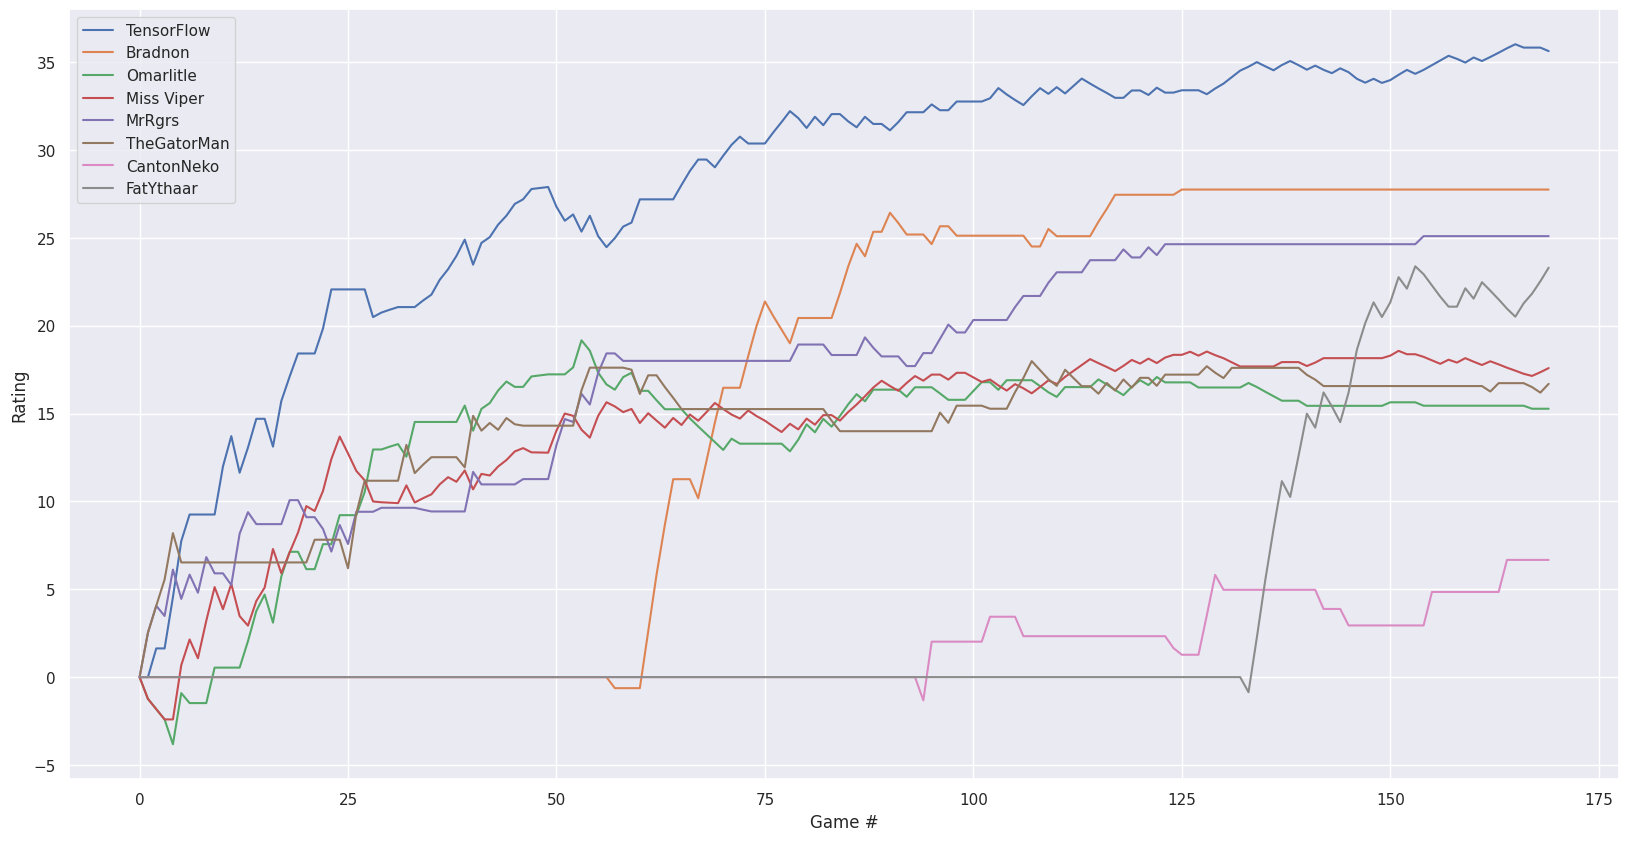

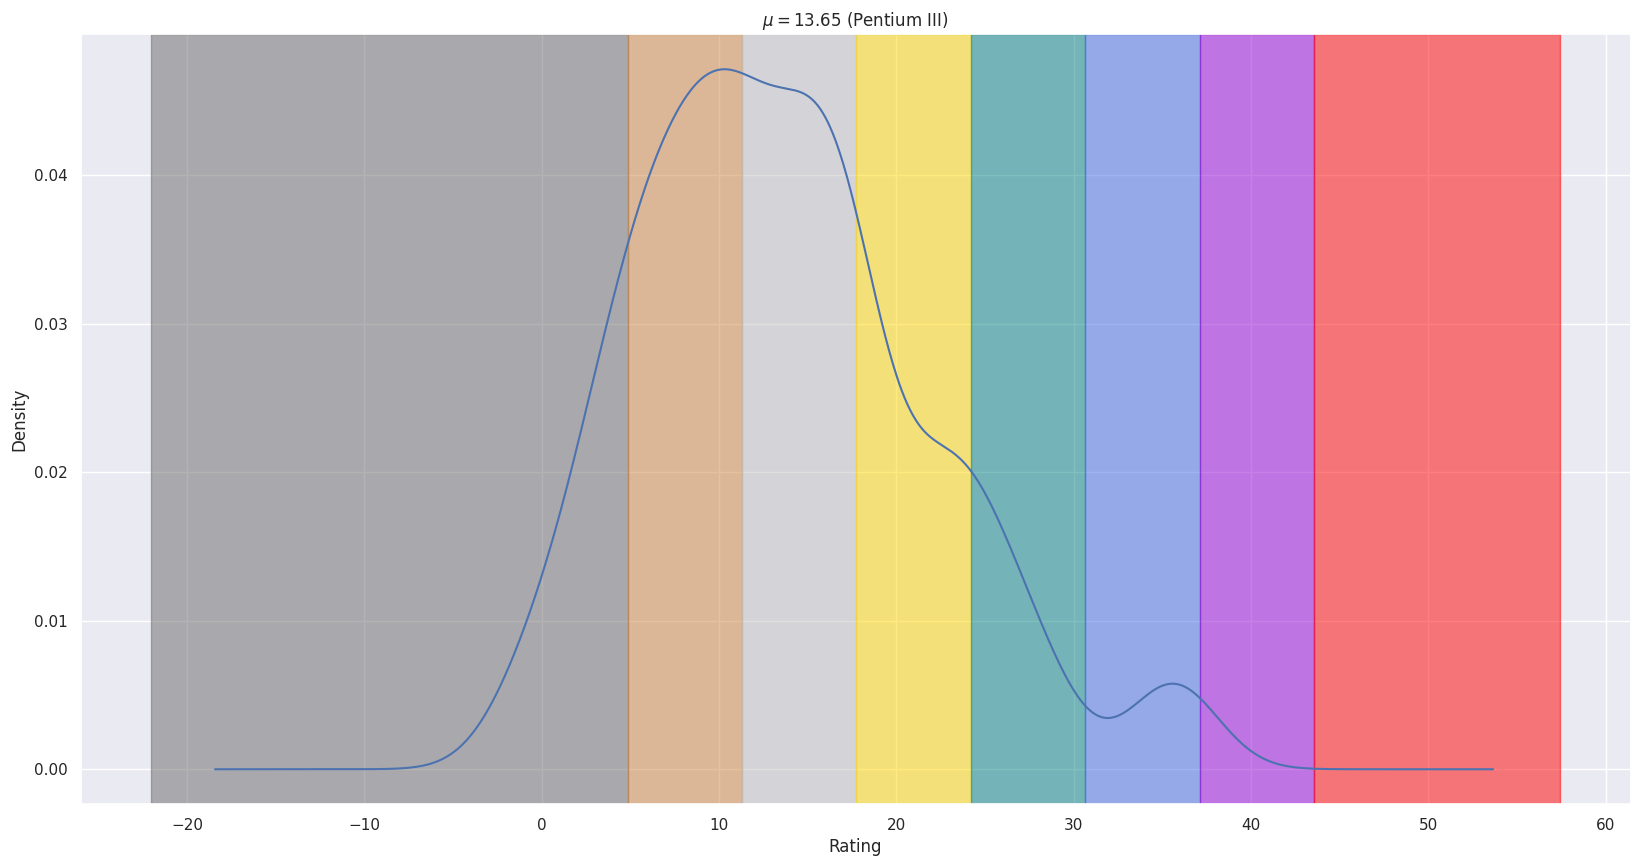

In [14]:
show_draft_stats(matches,num_shown=10,min_games=7)
show_player_wr_by_champ(matches, name='FatYthaar')
name_list = ['TensorFlow','Bradnon','Omarlitle','Miss Viper','MrRgrs','TheGatorMan','CantonNeko','FatYthaar']
plot_elo_history(ratings,name_list)
plot_rank_dist(ratings,bw_method=0.3)

# Synergy

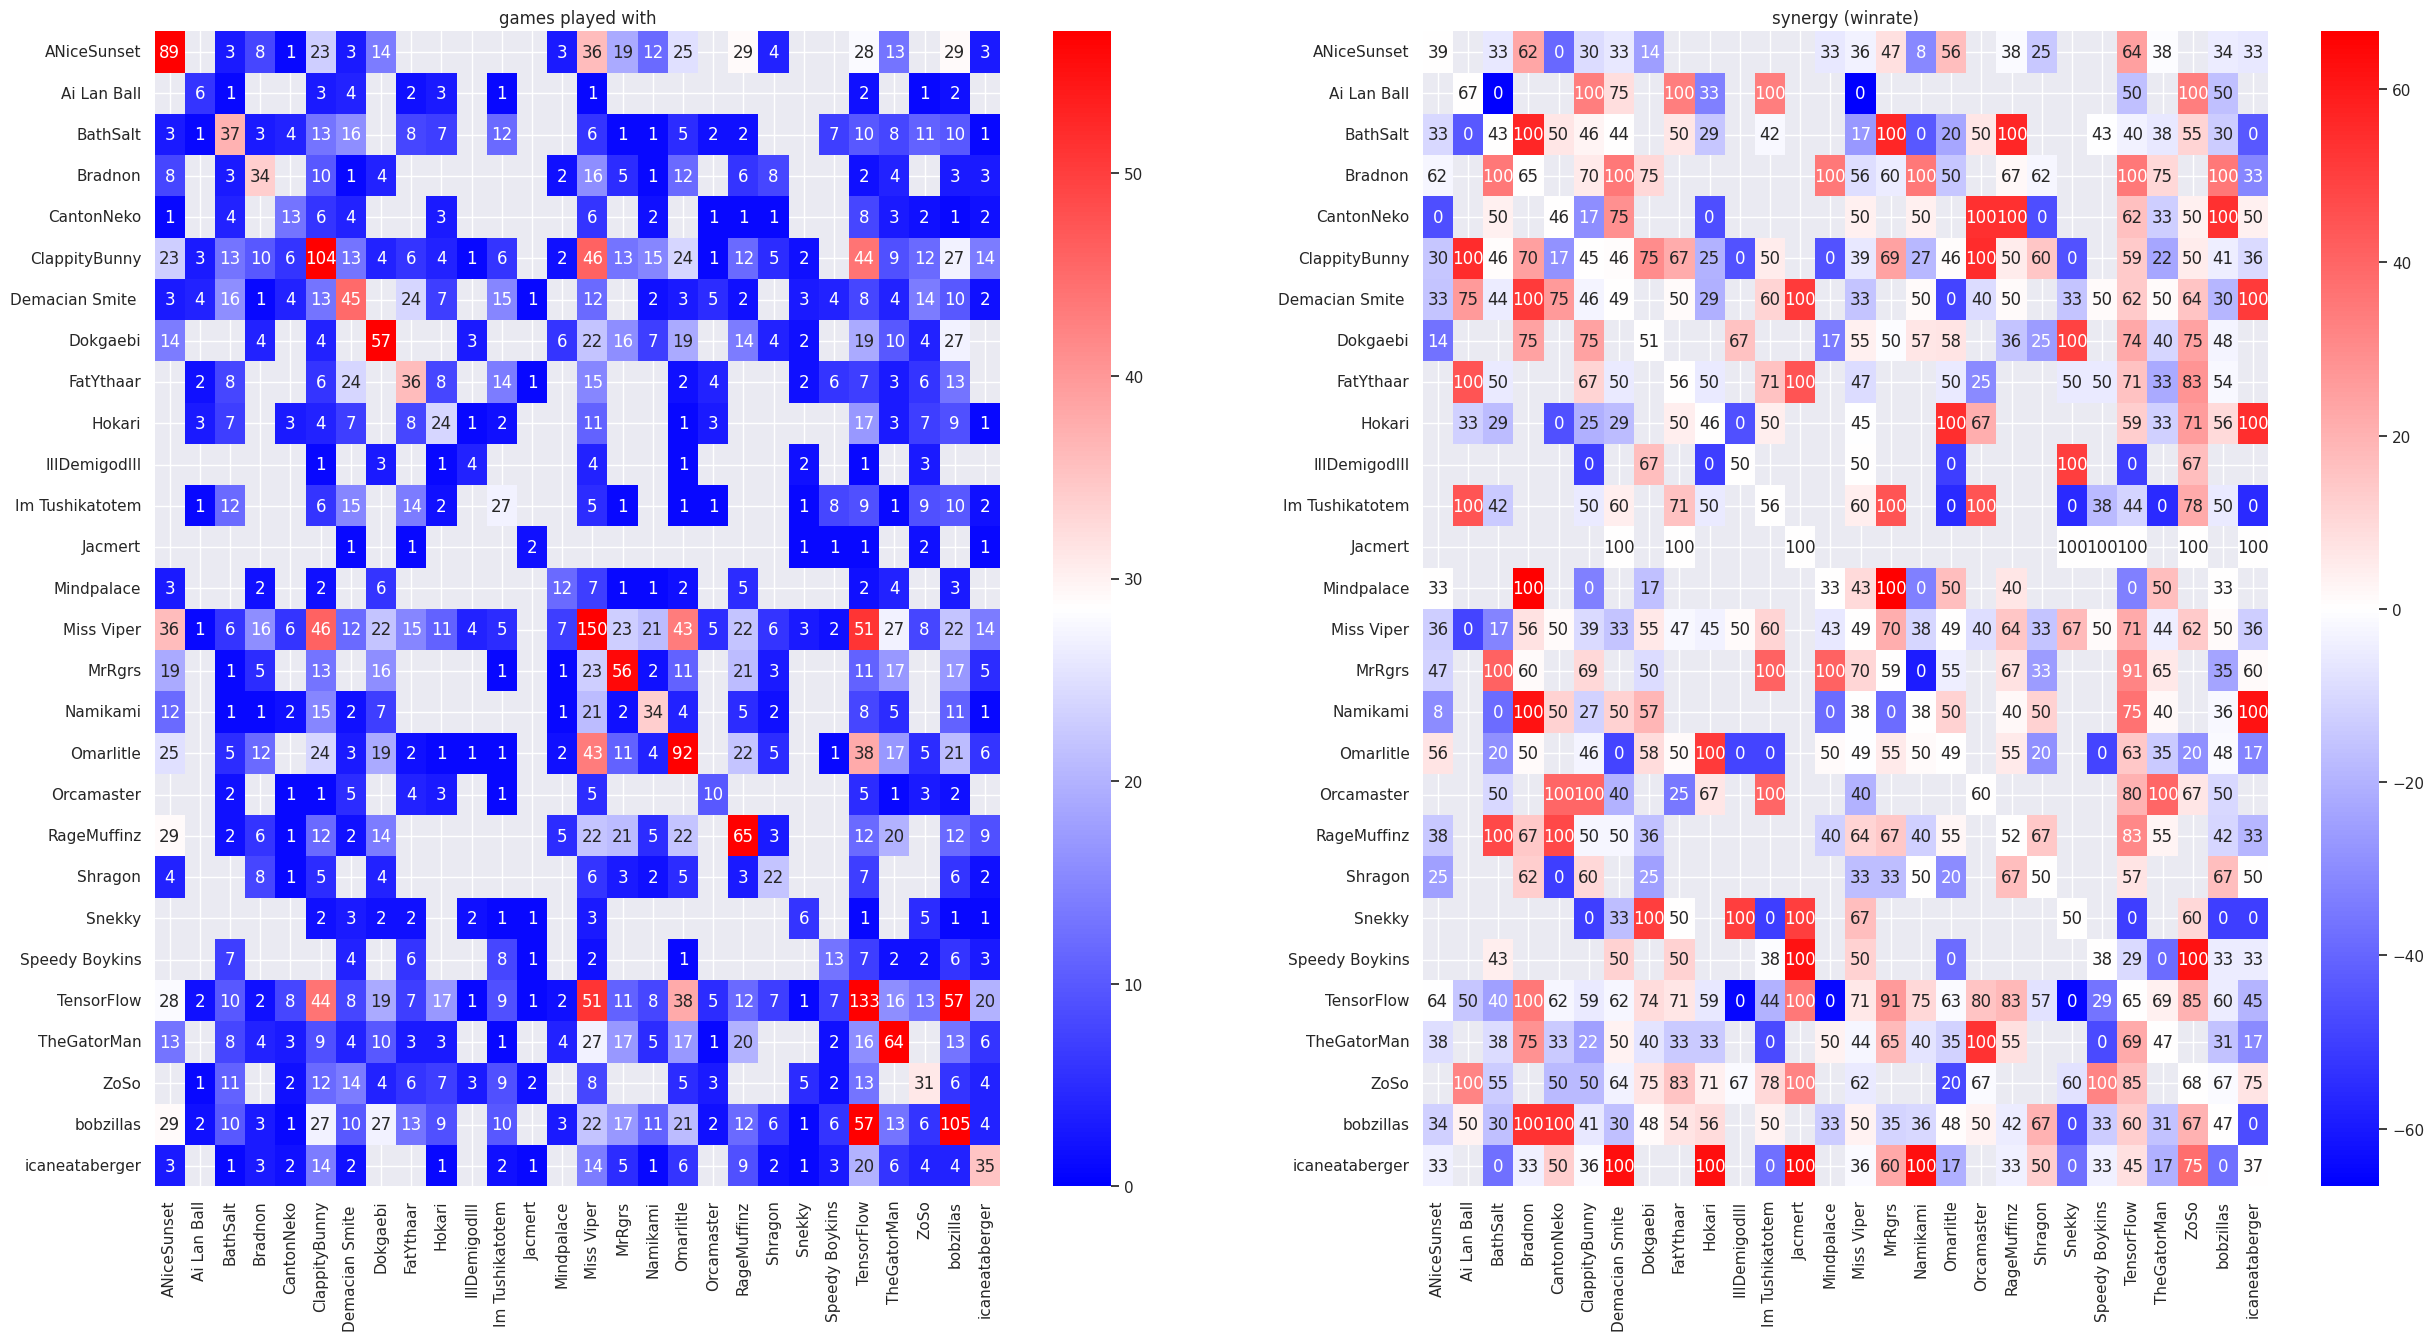

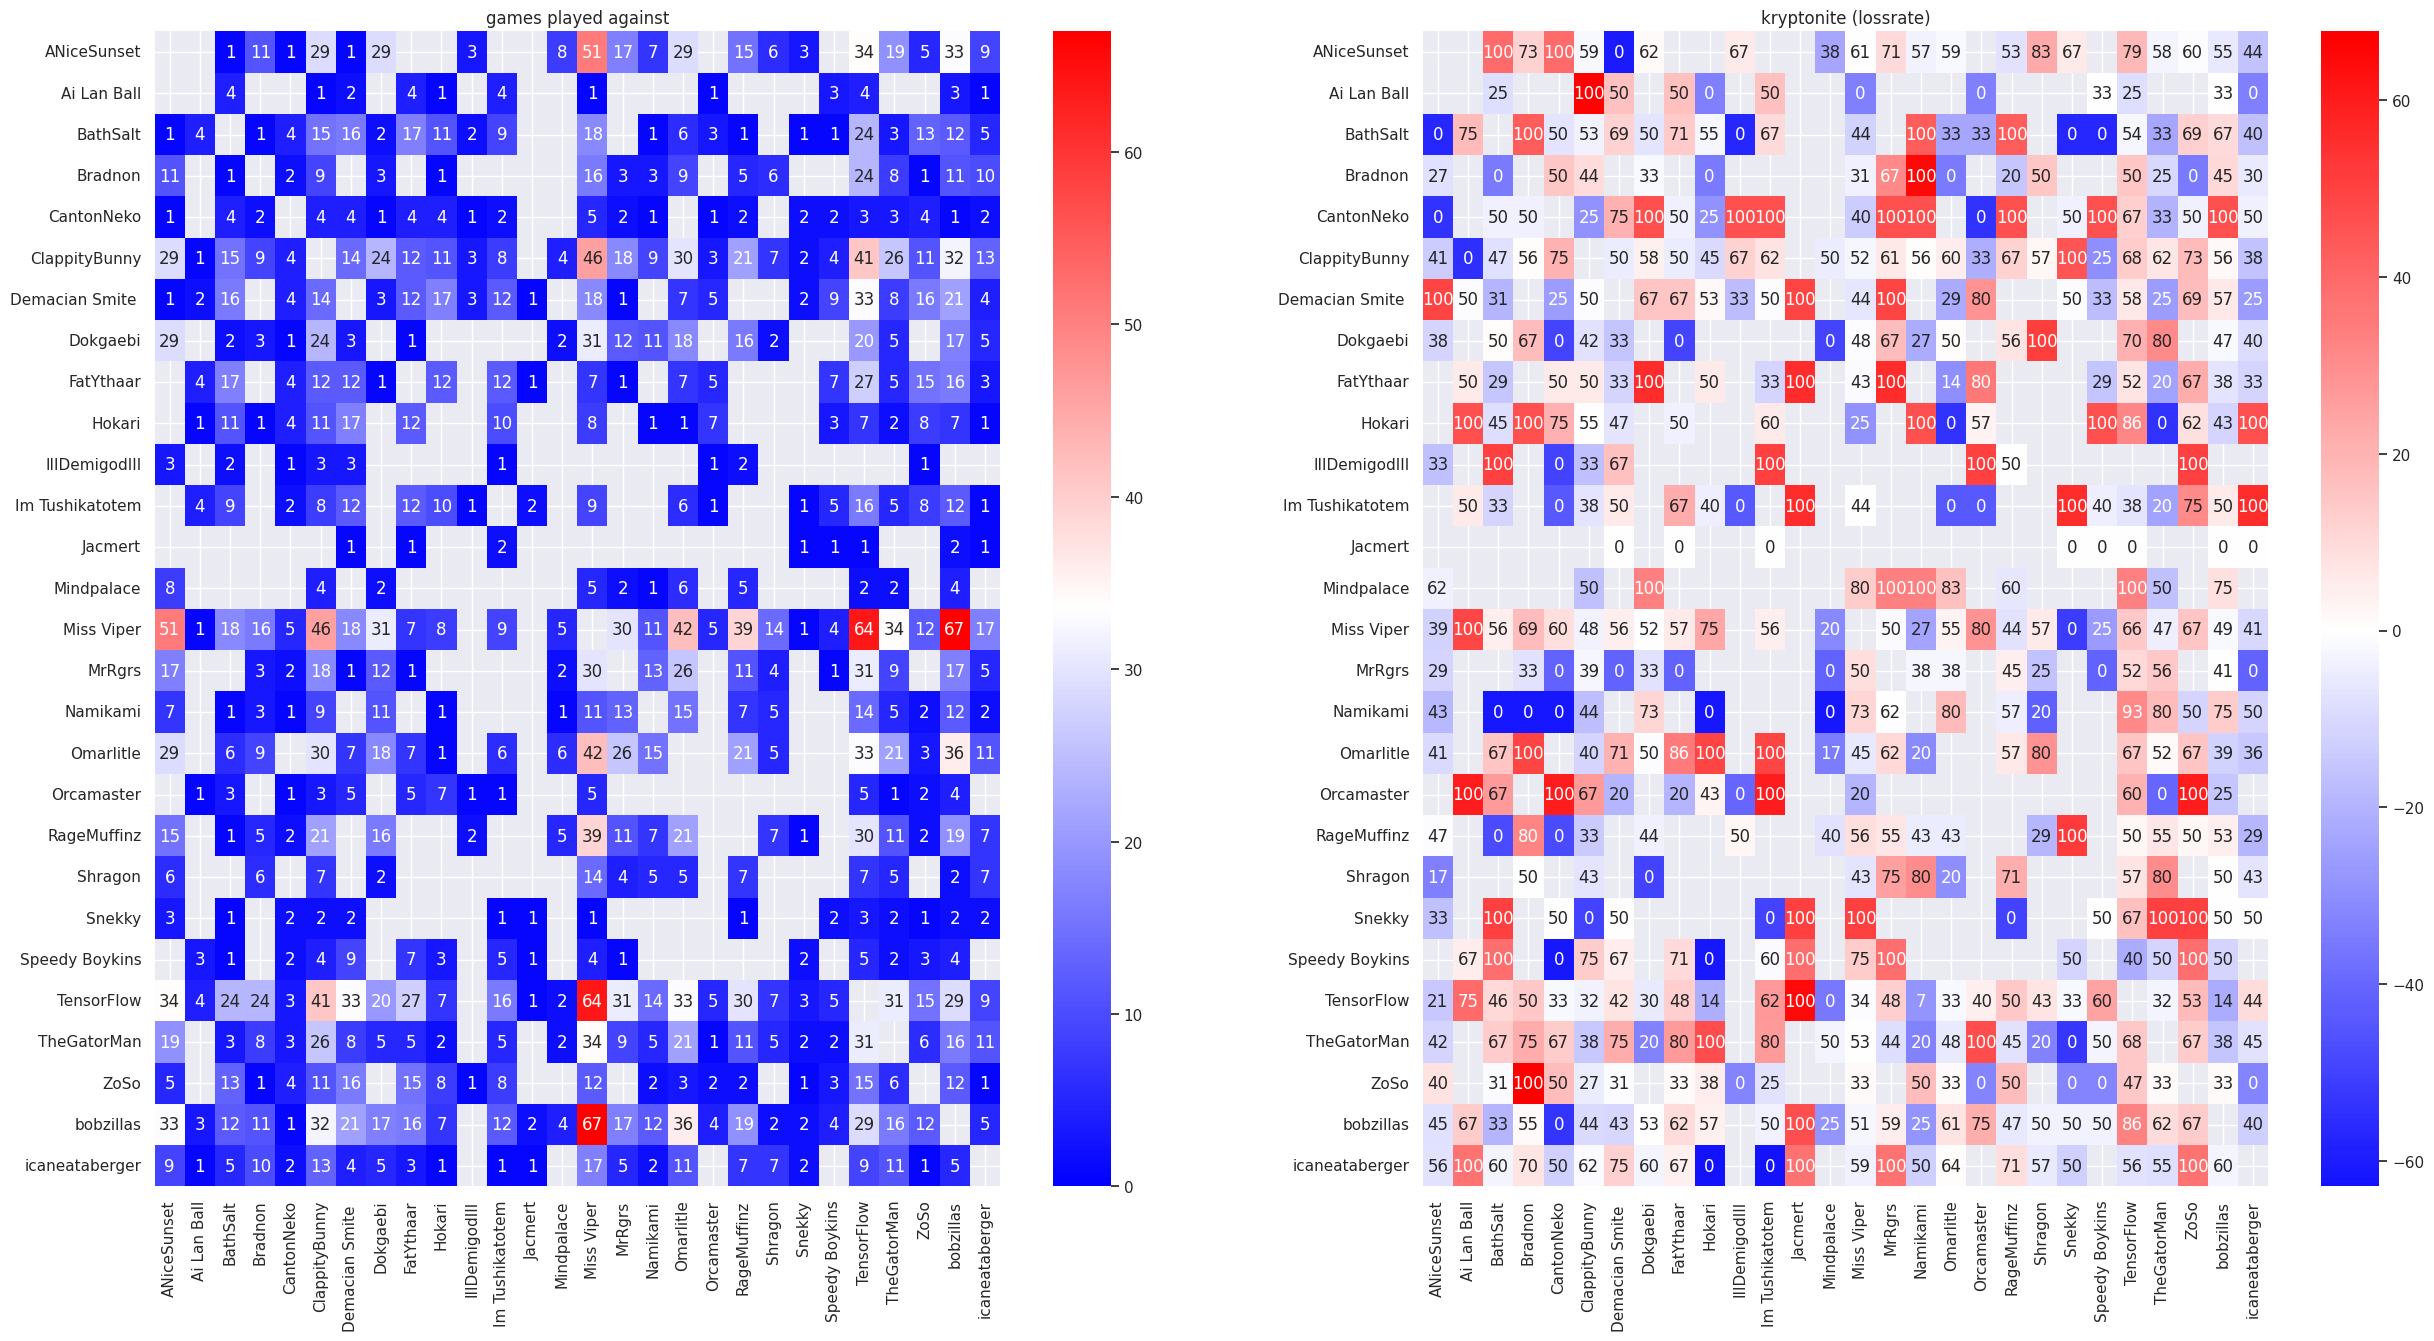

In [15]:
synergy(wins, totals_with)
kryptonite(wins, totals_with, losses, totals_against)

# Matchmaking

In [16]:
display_matchmaking(ratings,sortby='quality') #sortby happiness or quality